## Experiment Setup

###  Random seed / Colab / CUDA related

In [1]:
import time
import datetime
import os

# Use Google Colab
use_colab = True

# Is this notebook running on Colab?
# If so, then google.colab package (github.com/googlecolab/colabtools)
# should be available in this environment

# Previous version used importlib, but we could do the same thing with
# just attempting to import google.colab
try:
    from google.colab import drive
    colab_available = True
except:
    colab_available = False

if use_colab and colab_available:
    drive.mount('/content/drive')
    
    # If there's a package I need to install separately, do it here
    !pip install pyro-ppl

    # cd to the appropriate working directory under my Google Drive
    %cd 'drive/My Drive/Colab Notebooks/bayesian-dl-experiments'
    
    # List the directory contents
    !ls

# IPython reloading magic
%load_ext autoreload
%autoreload 2

# Random seeds
# Based on https://pytorch.org/docs/stable/notes/randomness.html
random_seed = 682

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/bayesian-dl-experiments
experiment_comparison_toy.ipynb  LICENSE    ronald_bdl
experiment_nn_capacity_1.ipynb	 README.md  test_results


### Third party libraries (NumPy, PyTorch, Pyro)

In [2]:
# Third party libraries import
import numpy as np
import torch
import pyro
import matplotlib.pyplot as plt

# Print version information
print("NumPy Version: " + np.__version__)
print("PyTorch Version: " + torch.__version__)
print("Pyro Version: " + pyro.__version__)

NumPy Version: 1.17.4
PyTorch Version: 1.3.1
Pyro Version: 1.0.0


In [0]:
# More imports...
from torch.utils.data import random_split, DataLoader
from ronald_bdl import datasets, models
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, NUTS, MCMC

# pyplot setting
%matplotlib inline

# torch.device / CUDA Setup
use_cuda = True

if use_cuda and torch.cuda.is_available():
    torch_device = torch.device('cuda')

    torch.backends.cudnn.deterministic = True
    # Note: https://discuss.pytorch.org/t/what-does-torch-backends-cudnn-benchmark-do/5936
    torch.backends.cudnn.benchmark = False
    use_pin_memory = True # Faster Host to GPU copies with page-locked memory
else:
    torch_device = torch.device('cpu')
    use_pin_memory = False

### Variable settings

In [0]:
"""
Toy dataset generation based on the experiment from 
the Probabilstic Backpropagation paper (Hernandez-Lobato & Adams, 2015)
"""
# Random seed for toy dataset
dataset_toy_random_seed = 691

# Toy dataset size
dataset_toy_size = 20

# Toy dataset x distribution (uniform) parameters
dataset_toy_x_low = -4
dataset_toy_x_high = 4

# Toy dataset y distribution (normal with noise)
dataset_toy_y_mean = 0
dataset_toy_y_std = 9

In [0]:
"""
MC Dropout related
"""
# Dropout rate
dropout_rate = 0.5

# L2 regularization strength
reg_strength = 0.3

# Epochs
n_epochs = 4000

# Optimizer learning rate
learning_rate = 0.03

# Loss function type
loss_function_type = 'mse_loss'

# Number of test predictions (for each data point)
n_predictions = 10000

In [0]:
# Test start time
test_start_time = datetime.datetime.today().strftime('%Y%m%d%H%M')

# Directory to store the results for this experiment
test_results_path = os.path.join(
    './test_results',
    'comparison_toy',
    (
        test_start_time 
        + '_' + str(n_epochs) 
        + '_' + str(dropout_rate) 
        + '_' + str(reg_strength) 
        + '_' + str(loss_function_type) 
        + '_' + str(n_predictions))
)

# Create the directory if it doesn't exist
os.makedirs(test_results_path, exist_ok=True)

## Prepare data

### Get the data as a torch Dataset object

In [7]:
dataset = datasets.ToyDatasets(
    random_seed=dataset_toy_random_seed,
    n_samples=dataset_toy_size,
    x_low=dataset_toy_x_low,
    x_high=dataset_toy_x_high,
    y_mean=dataset_toy_y_mean,
    y_std=dataset_toy_y_std,
)

# Get the test data
X_test = torch.linspace(dataset_toy_x_low, dataset_toy_x_high, 100).reshape(100, 1)

# Print the size of the dataset
print("dataset size = " + str((len(dataset), dataset.n_features)))

dataset size = (20, 1)


## Define network

In [0]:
uncertainty_methods = {}

# MC (Bernoulli) dropout
#uncertainty_methods['mc_dropout'] = models.FCNetMCDropout(
#    input_dim=dataset.n_features, 
#    output_dim=dataset.n_targets,
#    hidden_dim=100,
#    n_hidden=0,
#    dropout_rate=dropout_rate,
#    dropout_type='bernoulli',
#)

# Vanilla Variational Inference
uncertainty_methods['vi'] = models.FCNetPyro(
    input_dim=dataset.n_features, 
    output_dim=dataset.n_targets,
    hidden_dim=10,
    n_hidden=0,
    torch_device=torch_device,
)

# HMC (NUTS)
uncertainty_methods['hmc'] = models.FCNetPyro(
    input_dim=dataset.n_features, 
    output_dim=dataset.n_targets,
    hidden_dim=10,
    n_hidden=0,
    torch_device=torch_device,
)

## Train the network

### Train/test the model

In [9]:
for key, network in uncertainty_methods.items():
    # Reset the random number generator for each method (to produce identical results)
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    pyro.set_rng_seed(random_seed)
    
    # Print the method name
    print("Now running " + str(key))
    
    # Send the whole model to the selected torch.device
    network.to(torch_device)

    # Print the network structure
    print(network)
    print()

    # Initialize training data loader
    train_loader = DataLoader(dataset, batch_size=len(dataset))
    
    """
    Optimizer Setup
    """

    if isinstance(network, models.FCNetMCDropout):
        # Adam optimizer
        # https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam
        # NOTE: Need to set L2 regularization from here
        optimizer = torch.optim.Adam(
            network.parameters(),
            lr=learning_rate,
            weight_decay=reg_strength, # L2 regularization
        )

        # Mean Squared Error for loss function to minimize
        objective = torch.nn.MSELoss()

    elif isinstance(network, models.FCNetPyro):
        if key == 'vi':
            optimizer = pyro.optim.Adam({"lr": learning_rate})
            svi = SVI(network, network.guide, optimizer, loss=Trace_ELBO())
        elif key == 'hmc':
            nuts_kernel = NUTS(network)
            mcmc = MCMC(nuts_kernel, num_samples=2000)
            
        pyro.clear_param_store()
    
    """
    Training
    """

    # Model to train mode
    network.train()

    # Record training start time (for this method)
    tic = time.time()
    
    if key == 'hmc':
        dataset.data_x.to(torch_device)
        dataset.data_y.to(torch_device)
        mcmc.run(dataset.data_x, dataset.data_y)
    else:
        for epoch in range(n_epochs): # loop over the dataset multiple times

            for i, data in enumerate(train_loader):
                # get the inputs; data is a list of [inputs, labels]
                inputs, targets = data

                # Store the batch to torch_device's memory
                inputs.to(torch_device)
                targets.to(torch_device)

                if isinstance(network, models.FCNetMCDropout):
                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward + backward + optimize
                    outputs = network(inputs)

                    if loss_function_type in ('test_ll_mc', 'rmse_mc'):
                        _, _, _, metrics = network.predict_dist(
                            inputs, n_predictions, y_test=targets, reg_strength=reg_strength)

                        if loss_function_type == 'test_ll_mc':
                            total_loss = -(metrics[loss_function_type])
                    else:
                        total_loss = objective(outputs, targets)

                    total_loss.backward()

                    optimizer.step()

                elif isinstance(network, models.FCNetPyro):
                    pyro.clear_param_store()
                    # calculate the loss and take a gradient step
                    total_loss = svi.step(inputs, targets)

            if epoch % 100 == 0:
                print("[iteration %04d] loss: %.4f" % (epoch + 1, total_loss))
            
    # Record training end time
    toc = time.time()

    # Report the final loss
    print("final loss = " + str(total_loss))            

    # Report the total training time
    print("training time = " + str(toc - tic) + " seconds")
    
    print()

Now running vi
FCNetPyro(
  (input): PyroModuleDict(
    (linear): PyroLinear(in_features=1, out_features=10, bias=True)
    (relu): PyroReLU()
  )
  (output): PyroLinear(in_features=10, out_features=1, bias=True)
  (guide): AutoDiagonalNormal()
)

[iteration 0001] loss: 60948.0506
[iteration 0101] loss: 51516.6090
[iteration 0201] loss: 50032.9702
[iteration 0301] loss: 49640.7920
[iteration 0401] loss: 49500.3921
[iteration 0501] loss: 49377.7288
[iteration 0601] loss: 49364.5173
[iteration 0701] loss: 49301.8903
[iteration 0801] loss: 49271.6420
[iteration 0901] loss: 49249.8900
[iteration 1001] loss: 49229.3101
[iteration 1101] loss: 49226.1314
[iteration 1201] loss: 49208.3586
[iteration 1301] loss: 49202.8781
[iteration 1401] loss: 49189.3625
[iteration 1501] loss: 49181.8607
[iteration 1601] loss: 49192.2836
[iteration 1701] loss: 49174.2074
[iteration 1801] loss: 49164.3371
[iteration 1901] loss: 49165.1192
[iteration 2001] loss: 49166.3719
[iteration 2101] loss: 49157.0098
[it

Warmup:   0%|          | 0/4000 [00:00, ?it/s]

final loss = 49146.300850868225
training time = 15.235660314559937 seconds

Now running hmc
FCNetPyro(
  (input): PyroModuleDict(
    (linear): PyroLinear(in_features=1, out_features=10, bias=True)
    (relu): PyroReLU()
  )
  (output): PyroLinear(in_features=10, out_features=1, bias=True)
  (guide): AutoDiagonalNormal()
)



Sample: 100%|██████████| 4000/4000 [09:05,  7.33it/s, step size=7.96e-02, acc. prob=0.916]

final loss = 49146.300850868225
training time = 545.4901750087738 seconds



testing time = 5.105950117111206 seconds

Mean = tensor([-2.9107e-01, -2.6753e-01, -1.7218e-01, -1.3937e-01, -2.3374e-01,
        -2.0086e-01, -1.7624e-01, -1.9880e-01, -2.5340e-01, -2.7058e-01,
        -2.3171e-01, -2.3010e-01, -1.9107e-01, -1.2130e-01, -1.6430e-01,
        -1.3679e-01, -1.1184e-01, -6.2034e-02, -2.1732e-01, -8.8027e-02,
        -1.6776e-01, -2.2953e-01, -1.1050e-01, -8.6696e-02, -1.9713e-01,
        -1.8729e-01, -1.5145e-01, -2.1365e-01, -5.4384e-02, -1.3596e-01,
        -9.9213e-02, -4.3071e-02, -5.6538e-02, -5.3691e-02, -1.1349e-01,
        -1.0501e-01, -7.6483e-02, -1.4640e-01, -6.1528e-02, -6.5748e-02,
        -9.7094e-02, -1.2976e-02,  1.5499e-02, -6.8728e-02, -1.1727e-01,
        -8.7248e-02,  8.4417e-03, -5.2796e-02, -8.6824e-02, -5.2055e-02,
        -1.2827e-01, -6.8834e-02, -1.9345e-02, -1.3027e-01, -2.5132e-02,
         1.3007e-02, -1.1268e-02, -2.7455e-02,  6.4214e-02, -7.6738e-02,
         4.4462e-02,  5.5587e-05, -7.4068e-02, -3.8438e-02,  1.0860e-02,
  

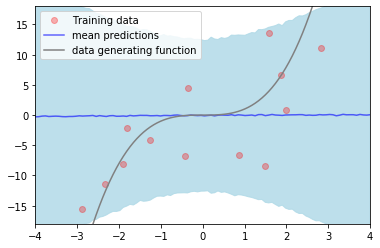

testing time = 5.150808095932007 seconds

Mean = tensor([-0.1029, -0.0379, -0.0395, -0.0306,  0.0318,  0.0159, -0.0899, -0.0357,
        -0.0581, -0.0462,  0.0105, -0.0252,  0.0177, -0.0821, -0.0568,  0.0200,
         0.0046, -0.0340, -0.0365,  0.1359, -0.0582,  0.0567, -0.0280,  0.0237,
        -0.0739, -0.0211,  0.0239, -0.0043,  0.0793, -0.0595,  0.0925, -0.0231,
        -0.0245,  0.0703,  0.0626,  0.0377, -0.0606,  0.0397, -0.0521,  0.0482,
         0.0728, -0.0537,  0.0236, -0.0212,  0.0250,  0.1692, -0.0800,  0.0717,
        -0.0483, -0.1080, -0.0480, -0.0193, -0.0371, -0.0269,  0.0703,  0.0253,
        -0.0335, -0.0143, -0.1223, -0.0140, -0.0444,  0.0132,  0.0218,  0.0096,
         0.0147, -0.0106, -0.0171, -0.0304,  0.0226, -0.0072,  0.0795,  0.0862,
         0.0073, -0.0071,  0.1246,  0.0287,  0.1108,  0.0654,  0.0791,  0.0827,
         0.0656,  0.0949,  0.0922,  0.0245,  0.0522,  0.0499, -0.0272, -0.0245,
         0.1030,  0.1019,  0.0128,  0.0558,  0.0504,  0.0351,  0.0381, 

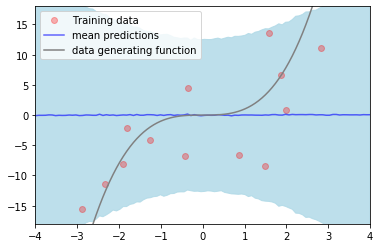

In [10]:
for key, network in uncertainty_methods.items():

    """
    Testing
    """

    # Model to eval mode
    network.eval()

    # Record testing start time (for this split)
    tic_testing = time.time()    
    
    predictions, mean, var, metrics = network.predict_dist(X_test, n_predictions)
    
    # Record testing end time
    toc_testing = time.time()
    
    # Report the total testing time
    print("testing time = " + str(toc_testing - tic_testing) + " seconds")
    
    """
    Print results
    """

    print()
    print("Mean = " + str(mean.flatten()))
    print("Variance = " + str(var.flatten()))
    
    # store additional metrics
    if len(metrics) > 0:
        for key, value in metrics.items():
            print(str(key) + " = " + str(value))
        print()
             
    # Plot the uncertainty measured by each methods
    plt.figure()
    
    # Fix the scales of x-axis and y-axis
    plt.xlim(dataset_toy_x_low, dataset_toy_x_high)
    plt.ylim(dataset_toy_y_mean-2*dataset_toy_y_std, dataset_toy_y_mean+2*dataset_toy_y_std)

    # Distributions around the predictions
    plt.fill_between(
        X_test.flatten(), 
        (mean.detach().numpy() - 2*torch.sqrt(var).detach().numpy()).flatten(),
        (mean.detach().numpy() + 2*torch.sqrt(var).detach().numpy()).flatten(),
        color='lightblue', alpha=0.8)

    # Train data
    plt.plot(dataset.data_x, dataset.data_y, 'or', label='Training data', alpha=0.3)

    # MC prediction
    plt.plot(X_test, mean.detach().numpy(), 'blue', label='mean predictions', alpha=0.6)
    
    # Original data generating function without noise
    plt.plot(X_test, X_test ** 3, 'gray', label='data generating function')    
    
    plt.legend()
    
    plt.savefig(os.path.join(test_results_path, str(key) + '.png'))
    
    plt.show()